In [40]:
import pandas as pd
import numpy as np
import sqlite3
import re
from nltk import word_tokenize

In [41]:
def get_new_cols(df):
    """
    Remove white spaces in column names of data frames
    """ 
    cols = df.columns.values
    new_cols = [i.replace(' ','') for i in cols]
    col_dict = dict()
    for a,b in zip(cols, new_cols):
         col_dict[a] = b
    df.rename(col_dict, axis=1, inplace=True)
    return(df)

In [42]:
sales = pd.read_csv('Iowa_Liquor_Sales.csv', low_memory=False)
get_new_cols(sales)
sales.head()

,Invoice/ItemNumber,Date,StoreNumber,StoreName,Address,City,ZipCode,StoreLocation,CountyNumber,County,...,ItemNumber,ItemDescription,Pack,BottleVolume(ml),StateBottleCost,StateBottleRetail,BottlesSold,Sale(Dollars),VolumeSold(Liters),VolumeSold(Gallons)
0,S31296100034,03/16/2016,3762,Wine and Spirits Gallery,7690 HICKMAN RD,WINDSOR HEIGHTS,50322,NaN,77.0,Polk,...,80457,Ryan's Cream Liqueur,12,1000,7.23,10.85,1,10.85,1.0,0.26
1,INV-20599500022,07/15/2019,4320,Fareway Stores #470 / Perry,NaN,NaN,NaN,NaN,NaN,NaN,...,10008,Scoresby Rare Scotch,6,1750,10.50,15.75,6,94.50,10.5,2.77
2,INV-28403900139,07/01/2020,2643,Hy-Vee Wine and Spirits / Waterloo,2126 Kimball Ave,Waterloo,50701,NaN,7.0,BLACK HAWK,...,15628,Jameson,6,1750,32.48,48.72,2,97.44,3.5,0.92
3,INV-20560900100,07/11/2019,3456,Quick Shop / Clear Lake,NaN,NaN,NaN,NaN,NaN,NaN,...,10009,Scoresby Rare Scotch,12,1000,6.74,10.11,2,20.22,2.0,0.52
4,INV-20784900043,07/23/2019,5151,IDA Liquor,"500, Hwy 175",Ida Grove,51445,NaN,47.0,IDA,...,100107,Captain Morgan OSR Glass w/50ml Apple Smash & ...,6,1850,18.00,27.00,6,162.00,11.1,2.93


# Invoice Table

In [43]:
trans_col = ['Invoice/ItemNumber',
             'Date',
             'StoreNumber',
             'ItemNumber',
             'VendorNumber',
             'Pack',
             'BottleVolume(ml)',
             'BottlesSold',
             'Sale(Dollars)',
             'VolumeSold(Liters)']
invoice = sales[trans_col].copy()
invoice.rename({'Invoice/ItemNumber':'Invoice',
                'BottleVolume(ml)':'BottleVolume',
                'Sale(Dollars)':'Sale',
                'VolumeSold(Liters)':'VolumeSold'},
                axis=1,
                inplace=True)
invoice.head()

,Invoice,Date,StoreNumber,ItemNumber,VendorNumber,Pack,BottleVolume,BottlesSold,Sale,VolumeSold
0,S31296100034,03/16/2016,3762,80457,330.0,12,1000,1,10.85,1.0
1,INV-20599500022,07/15/2019,4320,10008,421.0,6,1750,6,94.50,10.5
2,INV-28403900139,07/01/2020,2643,15628,370.0,6,1750,2,97.44,3.5
3,INV-20560900100,07/11/2019,3456,10009,421.0,12,1000,2,20.22,2.0
4,INV-20784900043,07/23/2019,5151,100107,260.0,6,1850,6,162.00,11.1


In [44]:
price_col = ['ItemNumber', 'Date', 'StateBottleRetail']
price = sales[price_col].copy()
price.drop_duplicates(['ItemNumber', 'StateBottleRetail'], 
                      keep='first', 
                      inplace=True)
price.head()

,ItemNumber,Date,StateBottleRetail
0,80457,03/16/2016,10.85
1,10008,07/15/2019,15.75
2,15628,07/01/2020,48.72
3,10009,07/11/2019,10.11
4,100107,07/23/2019,27.00


# Store Table

In [45]:
store_col = ['StoreNumber',
             'StoreName',
             'Address',
             'City',
             'ZipCode',
             'StoreLocation',
             'CountyNumber',
             'County']
store = sales[store_col].drop_duplicates(store_col, keep='first').copy()
store.dropna(inplace=True)
store['StoreName'] = store['StoreName'].apply(lambda x: x.split('/')[0].strip())
store.head()

,StoreNumber,StoreName,Address,City,ZipCode,StoreLocation,CountyNumber,County
9,2663,Hy-Vee Food Store,8701 Douglas,Urbandale,50322,POINT (-93.739105 41.629364),77.0,POLK
18,2647,Hy-Vee #7,5050 Edgewood Rd,Cedar Rapids,52411,POINT (-91.701581 42.030129),57.0,LINN
24,5259,Gameday Liquor,924 Locust St,Glenwood,51534,POINT (-95.916235 41.284951),65.0,MILLS
27,5597,Liquor Tobacco & Gas,1401 Central Ave,Dubuque,52001,POINT (-90.66784 42.50649),31.0,DUBUQUE
31,3749,Wal-Mart 1526,1831 Lake Ave NW,Storm Lake,50588,POINT (-95.200739 42.663904),11.0,BUENA VIST


In [46]:
def standardize_name(name):
    name = str(name)
    name = name.replace("``",'')
    name = name.replace('"','')
    name = re.sub("[,`'#.]",'',name)
    name = str(name).lower().replace(' and ',' & ')
    store_name = word_tokenize(name)
    store_name = [str(i).capitalize().strip() for i in store_name]
    store_name = ' '.join(store_name)
    store_name = store_name.replace('  ',' ')
    return store_name

In [47]:
for col in ['StoreName', 'City', 'County']:
    store[col] = store[col].apply(standardize_name)

In [48]:
def get_location(location):
    if str(location)!='nan':
        location = str(location)
        location = re.findall(r'[-]\d.*\d', location)[0]
        lon, lat = location.split(' ')
        lon = round(float(lon), 2)
        lat = round(float(lat), 2)
        location = (lon, lat)
    else:
        location = np.nan
    return location

In [49]:
store['StoreLocation'] = store['StoreLocation'].map(get_location)

In [50]:
lon = list()
lat = list()
for location in store.StoreLocation.values:
    if str(location) != 'nan':
        lon.append(location[0])
        lat.append(location[1])
    else:
        lon.append(np.nan)
        lat.append(np.nan)

store['Latitude'] = lat
store['Longitude'] = lon
store.drop(columns=['StoreLocation'], inplace=True)

In [51]:
store.drop_duplicates(inplace=True)

In [52]:
store = store.groupby('StoreNumber').last().reset_index()

<AxesSubplot:xlabel='Longitude', ylabel='Latitude'>

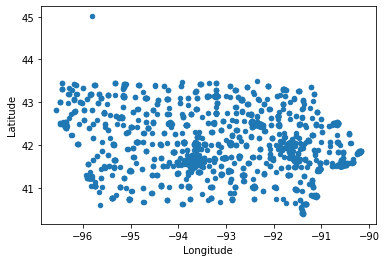

In [53]:
store.plot(kind='scatter',x='Longitude',y='Latitude')

In [54]:
# Fix data error (store number 56201, zip code is coded as 56201, which is wrong)
store.loc[(store.Longitude>-80) | (store.Latitude>44)]['ZipCode'] = 52601
store.loc[(store.Longitude>-80) | (store.Latitude>44)]['Longitude'] = 40.81
store.loc[(store.Longitude>-80) | (store.Latitude>44)]['Latitude'] = -91.11

<ipython-input-54-176ca9e6ab01>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  store.loc[(store.Longitude>-80) | (store.Latitude>44)]['ZipCode'] = 52601
<ipython-input-54-176ca9e6ab01>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  store.loc[(store.Longitude>-80) | (store.Latitude>44)]['Longitude'] = 40.81
<ipython-input-54-176ca9e6ab01>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats 

# Create product and vendor tables

In [55]:
products = pd.read_csv('Iowa_Liquor_Products.csv', low_memory=False)
get_new_cols(products)
products.drop(columns=['UPC', 'SCC'], inplace=True)
products.head()

,ItemNumber,CategoryName,ItemDescription,Vendor,VendorName,BottleVolume(ml),Pack,InnerPack,Age,Proof,ListDate,StateBottleCost,StateCaseCost,StateBottleRetail,ReportDate
0,901141,Special Order Items,Libertine Absinthe(French Absinthe) Mini,885.0,YAHARA BAY DISTILLERS INC,50,6,1,0,114,04/20/2012,4.82,28.90,7.23,05/01/2021
1,65017,Imported Cordials & Liqueurs,Galliano Liqueur,305.0,Mhw LTD,375,12,1,0,84,10/01/2012,10.75,129.00,16.13,05/01/2021
2,88152,100% Agave Tequila,Sauza 901 Silver,65.0,Jim Beam Brands,750,6,1,0,80,06/01/2014,13.12,78.72,19.68,05/01/2021
3,903796,Special Order Items,Bacardi Anejo DISCO,35.0,BACARDI USA INC,750,12,1,0,80,09/01/1990,7.75,93.00,11.63,05/01/2021
4,905846,Scotch Whiskies,Ron Burgundy,305.0,Mhw LTD,750,12,1,0,80,10/01/2014,14.61,175.25,21.92,05/01/2021


# Product Table

In [56]:
item_col = ['ItemNumber',
            'CategoryName',
            'ItemDescription',
            'Vendor',
            'VendorName',
            'BottleVolume(ml)',
            'Pack',
            'InnerPack',
            'Age',
            'Proof']
item = products[item_col].copy()
item.rename({'Vendor':'VendorNumber',
             'BottleVolume(ml)':'BottleVolume'}, axis=1, inplace=True)
item.drop_duplicates(keep='first', inplace=True)
item.head()

,ItemNumber,CategoryName,ItemDescription,VendorNumber,VendorName,BottleVolume,Pack,InnerPack,Age,Proof
0,901141,Special Order Items,Libertine Absinthe(French Absinthe) Mini,885.0,YAHARA BAY DISTILLERS INC,50,6,1,0,114
1,65017,Imported Cordials & Liqueurs,Galliano Liqueur,305.0,Mhw LTD,375,12,1,0,84
2,88152,100% Agave Tequila,Sauza 901 Silver,65.0,Jim Beam Brands,750,6,1,0,80
3,903796,Special Order Items,Bacardi Anejo DISCO,35.0,BACARDI USA INC,750,12,1,0,80
4,905846,Scotch Whiskies,Ron Burgundy,305.0,Mhw LTD,750,12,1,0,80


In [57]:
def agg_cat(name):
    name = str(name)
    name = re.sub('Neutral Grain Spirits.*','Neutral Grain Spirits',name)
    name = re.sub(r'Temporary.*Specialty','Temporary & Specialty',name)
    name = re.sub(r'Cocktails.*RTD','Cocktails / RTD',name)
    
    if re.findall(r'\bLiqueurs?\b', name):
        name = 'Liqueurs'
    elif re.findall(r'Schnapps', name):
        name = 'Liqueurs'
    elif re.findall(r'Triple Sec', name):
        name = 'Liqueurs'
    elif re.findall(r'Brand(y\b|ies\b)', name):
        name = 'Brandies'
    elif re.findall(r'Bourbon', name):
        name = 'Whiskies'
    elif re.findall(r'Single Malt Scotch', name):
        name = 'Whiskies'
    elif re.findall(r'(Whisk)(ies|y)', name):
        name = 'Whiskies'
    elif re.findall(r'\bVodkas?\b', name):
        name = 'Vodka'  
    elif re.findall(r'\bRums?\b', name):
        name = 'Rum'
    elif re.findall(r'Tequila', name):
        name = 'Tequila'
    elif re.findall(r'Mezcal', name):
        name = 'Tequila'    
    elif re.findall(r'Gin', name):
        name = 'Gin'
    elif re.findall(r'Cocktails / RTD', name):
        name = 'Specialty'
    elif re.findall(r'Distilled \bSpirits?\b Specialty', name):
        name = 'Specialty'
    elif re.findall(r'Temporary & Specialty Packages', name):
        name = 'Specialty'
    elif re.findall(r'Special Order Items', name):
        name = 'Specialty'
    elif re.findall(r'Holiday VAP', name):
        name = 'Specialty'
    elif re.findall(r'Neutral Grain Spirits', name):
        name = 'Specialty'
    elif re.findall(r'Delisted', name):
        name = 'Delisted'
    return name

In [58]:
item['CategoryName'] = item['CategoryName'].map(agg_cat)
item.CategoryName.value_counts().sort_values(ascending=False)

Specialty            2822
Whiskies             2294
Vodka                1326
Liqueurs              995
Rum                   653
Tequila               627
Brandies              304
Gin                   276
Iowa Distilleries     115
Delisted               25
Name: CategoryName, dtype: int64

# Vednor Table

In [59]:
vendor = products[['Vendor', 'VendorName']].copy()
vendor.drop_duplicates(keep='first', inplace=True)
vendor.rename({'Vendor':'VendorNumber'}, axis=1, inplace=True)

# Create sqlite database

In [60]:
conn = sqlite3.connect('IowaLiquor.db')
IowaLiquor = conn.cursor()

# Create Invoice Table
IowaLiquor.execute('''CREATE TABLE Invoice
             ([Invoice] TEXT PRIMARY KEY,
             [Date] date,
             [StoreNumber] integer, 
             [ItemNumber] text,
             [VendorNumber] integer,
             [Pack] integer,
             [BottleVolume] integer,
             [BottlesSold] integer,
             [Sale] real,
             [VolumeSold] real)''')


# Create Vendor Table
IowaLiquor.execute('''CREATE TABLE Vendor
             ([VendorNumber] INTEGER PRIMARY KEY,
             [VendorName] text)''')

# Create Product Item
IowaLiquor.execute('''CREATE TABLE Item
             ([ItemNumber] TEXT PRIMARY KEY,
              [CategoryName] text,
              [ItemDescription] text,
              [VendorNumber] integer,
              [VendorName] text,
              [BottleVolume] real,
              [Pack] integer,
              [InnerPack] integer,
              [Age] integer,
              [Proof] real)''')

# Create Price Table
IowaLiquor.execute('''CREATE TABLE Price
             ([ItemNumber] text,
              [Date] date,
              [StateBottleRetail] real,
              PRIMARY KEY(ItemNumber, Date, StateBottleRetail))''')

# Create STORE Table
IowaLiquor.execute('''CREATE TABLE Store
             ([StoreNumber] INTEGER PRIMARY KEY,
              [StoreName] text,
              [Address] text,
              [City] text,
              [ZipCode] text,
              [Latitude] real,
              [Longitude] real,
              [CountyNumber] integer,
              [County] text)''')
conn.commit()

In [61]:
invoice.to_sql("Invoice", conn, if_exists='append', index = False)
price.to_sql("Price", conn, if_exists='append', index = False)
store.to_sql("Store", conn, if_exists='append', index = False)
item.to_sql("Item", conn, if_exists='append', index = False)
vendor.to_sql("Vendor", conn, if_exists='append', index = False)
conn.close()

In [62]:
# store_names = set(store['StoreName'])
# store_names_dict = dict()
# for name in store_names:
#     new_name = name.split('/')[0].strip()
    
#     ''' Fix typos'''
#     new_name = new_name.replace('Distilery','Distillery')
    
#     '''Remove LLC, CO, Ave, Inc, Outlet'''
#     if re.findall(r'\bLlc\b', new_name):
#         new_name = new_name.replace('Llc','').strip()
#     if re.findall(r'\bCo\b', new_name):
#         new_name = new_name.replace('Co','').strip()        
#     if re.findall(' Ave ', new_name):
#         new_name = new_name.replace('Ave','').strip()   
#     if re.findall(r'\bInc\b', new_name):
#         new_name = new_name.replace('Inc','').strip()   
#     if re.findall(r'Outlet\$', new_name):
#         new_name = new_name.replace('Outlet','').strip()  
#     if re.findall(r'\bIi\b', new_name):
#         new_name = new_name.replace('Ii','II').strip() 
        
#     if re.match('Ackley Super', new_name):
#         new_name = 'Ackley Super Foods'
#     if re.match('Caseys', new_name):
#         new_name = 'Caseys General Store'
#     if re.match('Audubon Food', new_name):
#         new_name = 'Audubon Food'
#     if re.match('Cubbys', new_name):
#         new_name = 'Cubbys'
#     if re.match('Hometown Foods', new_name):
#         new_name = 'Hometown Foods'        
#     if re.match('Hy-vee', new_name):
#         if re.match('Fast', new_name):
#             new_name = 'Hy-vee Fast & Fresh'  
#         elif re.match('Dollar', new_name):
#             new_name = 'Hy-vee Dollar Fresh' 
#         else:
#             new_name = 'Hy-vee'
#     if re.match('Kimmes', new_name):
#         new_name = 'Kimmes'
#     if re.match('Kum & Go', new_name):
#         new_name = 'Kum & Go'
#     if re.match('New Star', new_name):
#         new_name = 'New Star'
#     if re.match('Quillins', new_name):
#         new_name = 'Quillins Quality Foods'
#     if re.match('Quik Trip', new_name):
#         new_name = 'Quik Trip'
#     if re.match('Taylor Quik Pik', new_name):
#         new_name = 'Taylor Quik Pik'
#     if re.match('The Depot', name):
#         new_name = 'The Depot'
#     if re.match('Big Mart', name):
#         new_name = 'Big Mart'        
#     if re.match('Bp Fuel', name):
#         new_name = 'Bp'    
#     if re.match('Brew Oil', name):
#         new_name = 'Brew Oil'   
#     if re.match('Buckys Express', name):
#         new_name = 'Buckys'  
#     if re.match('Byron Supermarket', name):
#         new_name = 'Byron Supermarket'  
#     if re.match('Car-go-express', name):
#         new_name = 'Cargo Express'  
#     if re.match('Circle K', name):
#         new_name = 'Circle K'  
#     if re.match('Costco', name):
#         new_name = 'Costco Wholesale'
#     if re.match('Cvs Phamarcy', name):
#         new_name = 'Cvs'
#     if re.match('Dings Honkn Holler', name):
#         new_name = 'Dings Honk & Holler'
#     if re.match(r'Double.*D.*', name):
#         new_name = 'Double D Liquore Store'
#     if re.match('Dynos', name):
#         new_name = 'Dynos'
#     if re.match('Fareway Stores', name):
#         new_name = 'Fareway Stores'        
#     if re.match('Fas Mart', name):
#         new_name = 'Fas Mart'          
#     if re.match('Five Corners Liquor & Win', name):
#         new_name = 'Five Corners Liquor & Wine'        
#     if re.match('Flashmart', name):
#         new_name = 'Flashmart'         
#     if re.match('Gasland N8th St', name):
#         new_name = 'Gasland N 8th St'            
#     if re.match('Gm Minimart', name):
#         new_name = 'Gm Mini Mart'  
#     if re.match('H & A Mini Mart', name):
#         new_name = 'H & A Mini Mart'  
#     if re.match('Hartig Drug', name):
#         new_name = 'Hartig Drug'  
#     if re.match('Hawkeye Convenience Store', name):
#         new_name = 'Hawkeye Convenience Stores'
#     if re.match('Hubers Store', name):
#         new_name = 'Hubers Store Inc'
#     if re.match('Independence Ave Liquor & Food', name):
#         new_name = 'Independence Liquor & Food'        
#     if re.match('Jims Food', name):
#         new_name = 'Jims Foods'
#     if re.match('Johncys Liquor Store', name):
#         new_name = 'Johncys Liquor Store'        
#     if re.match('Karls Grocery', name):
#         new_name = 'Karls Grocery Store'         
#     if re.match('Katy Did General Store', name):
#         new_name = 'Katy Dids General Store'          
#     if re.match('Kwik Shop', name):
#         new_name = 'Kwik Shop'
#     if re.match('Kwik Stop', name):
#         new_name = 'Kwik Stop'
#     if re.match('Liquor Tobacco & Grocery - Mason City', name):
#         new_name = 'Liquor Tobacco & Grocery'        
#     if re.match('Loofts On 9 Liquor Here Or Liquor Th', name):
#         new_name = 'Loofts On 9 Liquor Here Or Liquor There' 
#     if re.match('Loganconvenience Store', name):
#         new_name = 'Logan Convenience Store'
#     if re.match('Mississippi River Distilling', name):
#         new_name = 'Mississippi River Distillery'
#     if re.match('Moes Mart', name):
#         new_name = 'Moes Mart'
#     if re.match('Nat Food Mart', name):
#         new_name = 'Nat Food Mart'
#     if re.match('New York Dollar Store', name):
#         new_name = 'New York Dollar Stores'
#     if re.match('No Frills Supermarkets', name):
#         new_name = 'No Frills Supermarkets'
#     if re.match('One Stop Shop', name):
#         new_name = 'One Stop Shop'
#     if re.match('Prime Mart', name):
#         new_name = 'Prime Mart'    
#     if re.match('Sams Club', name):
#         new_name = 'Sams Club'
#     if re.match('Select Mart', name):
#         new_name = 'Select Mart'        
#     if re.match('Shop N Save', name):
#         new_name = 'Shop N Save'           
#     if re.match('Shugars', name):
#         new_name = 'Shugars'           
#     if re.match('Smokin Joes', name):
#         new_name = 'Smokin Joes'   
#     if re.match('The Snack Shack', name):
#         new_name = 'The Snack Shack'  
#     if re.match('The Station', name):
#         new_name = 'The Station'  
#     if re.match('Station Mart', name):
#         new_name = 'Station Mart'           
#     if re.match('Super Quick Stop', name):
#         new_name = 'Super Quick Stop'    
#     if re.match('Super Saver Liquor -muscatine', name):
#         new_name = 'Super Saver Liquor Of Muscatine'        
#     if re.match('Super Stop', name):
#         new_name = 'Super Stop'  
#     if re.match('Super Target', name):
#         new_name = 'Target'          
#     if re.match('Target', name):
#         new_name = 'Target Store' 
#     if re.match('Tobacco  Plus', name):
#         new_name = 'Tobacco Plus'
#     if re.match('Tobacco  Hut', name):
#         new_name = 'Tobacco Hut'   
#     if re.match('Wal-mart', name):
#         new_name = 'Wal-mart'  
#     if re.match('Walgreens', name):
#         new_name = 'Walgreens'     
#     if re.match('Yesway', name):
#         new_name = 'Yesway Store'
#     if re.match('World Liquor & Tobacco', name):
#         new_name = 'World Liquor & Tobacco'
#     if re.match('White Oak Station', name):
#         new_name = 'White Oak Station'
        
#     store_names_dict[name] = new_name.replace('  ','')
        
# store['StoreName'] = store['StoreName'].replace(store_names_dict)
# store = store.drop_duplicates(store_col, keep='first')
# store